# Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

이 노트북을 Agent, Tool 을 만들어서, Agent 가 Tool 이용하는 방법을 보여 드리고, 이를 Langfuse 를 통해서 추적을 가시화하는 것을 배웁니다.




---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/06_start_langgraph_bedrock_langfuse is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/06_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/06_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [2]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [3]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [4]:
# connection test
langfuse_handler.auth_check()

True

## 5. Tool 정의

In [5]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

tools = [search]

## 6. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [6]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id = "us.amazon.nova-pro-v1:0"

model = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
).bind_tools(tools)

## OpenAI
# model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)
model

RunnableBinding(bound=ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f7c47394340>, model_id='us.amazon.nova-pro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto']), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'Call to surf the web.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

## 7. LangGraph 정의

In [7]:
from typing import Literal

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


tool_node = ToolNode(tools)

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']

    # Invoking `model` will automatically infer the correct tracing context
    response = model.invoke(messages)

    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

## 8. Grpah 실행

In [8]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in sf")]},
    config={
            "configurable": {"thread_id": 42},
            "callbacks": [langfuse_handler],
        }
)

final_state["messages"][-1].content

'<thinking> The tool has provided the current weather conditions in San Francisco. I can now present this information to the user. </thinking>\n\nThe current weather in San Francisco is 60 degrees and foggy.'

### 전체 결과 보기

In [9]:
from pprint import pprint

# 데이터 출력
pprint(final_state, indent=2, width=100)

{ 'messages': [ HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='20b548c4-70fd-4fbb-a655-f117c8267efe'),
                AIMessage(content=[{'type': 'text', 'text': "<thinking> To determine the current weather in San Francisco, I need to use the 'search' tool to look up the latest weather information. </thinking>\n"}, {'type': 'tool_use', 'name': 'search', 'input': {'query': 'current weather in San Francisco'}, 'id': 'tooluse___EGFDElQWC37q0_KoipCQ'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e3913673-1aed-4d04-b0d0-adc6cfff5989', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 20 Mar 2025 10:19:05 GMT', 'content-type': 'application/json', 'content-length': '462', 'connection': 'keep-alive', 'x-amzn-requestid': 'e3913673-1aed-4d04-b0d0-adc6cfff5989'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [1188]}}, id='run-44d758db-e747-4637-a226-52ed1710d07b-0', tool_calls=[{'name

## 9. Graph 구조 보기

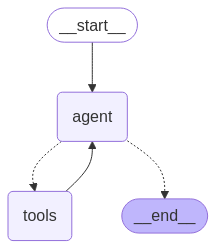

In [10]:
show_graph_dag(app)    

## 10. Langfuse Tracing Output
![langgrpah_tool_use.png](img/langgrpah_tool_use.png)